#Imports

In [ ]:
import warnings                     # For silencing non-critical warnings
import numpy as np                  # library fpr mathematical operatures
import pandas as pd                 # library for dataframes handling
import matplotlib.pyplot as plt     # library for plotting charts
import statsmodels.api as sm        #library for handling time series data
from statsmodels.tsa.seasonal import STL                      #Specific module for seasonal decomposition (trend/seasonal/residual)
from statsmodels.tsa.stattools import adfuller, kpss # Specific module for stationarity tests (ADF/KPSS)

from sklearn.preprocessing import StandardScaler, PolynomialFeatures #feature preprocessing

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score #For basic ML tasks
from sklearn.preprocessing import StandardScaler                # For feature scaling
from sklearn.feature_selection import SelectKBest, f_regression # For feature selection
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error  # For using regression metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # For using tree ensembles
from sklearn.linear_model import Ridge, LinearRegression                          # ML regression models

# Optional console tweaks
warnings.filterwarnings("ignore")       # hide unimportant warnings
pd.set_option("display.max_rows", None) # show full DataFrame rows when printing

#Finding header

In [ ]:
""" Finding the CSV’s header row (from first 200 lines) by scoring each line which matches with tokens which are header-like """

f = "/content/weather data file.csv"                                      # path to the CSV file

p = pd.read_csv(f, header=None, nrows=200, dtype=str)                     # preview first 200 rows as raw strings (no header)

score = lambda i: (                                                  # scoring function for row i:
    p.iloc[i].str.fullmatch(r'[A-Za-z_][\w \-/.]{0,40}').sum()       # + count cells that look like column names (regex: start with letter/_ then word/space-./ up to 41 chars)
    - p.iloc[i].str.contains(':', na=False).sum()                     # - penalize cells containing ':' (often not header-like)
    + (0.3 * p.iloc[i+1].str.contains(r'\d', na=False).sum()           # + small reward if the NEXT row has digits (likely data row under a header)
       if i + 1 < len(p) else 0)                                       #   (only if next row exists)
)

h = max(range(len(p)), key=score) if len(p) else 0                        # choose the row index with the highest score (or 0 if file is empty)

df = pd.read_csv(f, skiprows=h, header=0)                                 # read the CSV, skipping rows before h; treat row h as the header




#Exploratory Data Analysis

##Statistical analysis

In [ ]:
df.head(5) #reading first 5 rows of data frame

,date,maxtp,mintp,gmin,rain,cbl,wdsp,hm,ddhm,hg,soil,pe,evap,smd_wd,smd_md,smd_pd,glorad
0,01-Oct-09,12.4,8.2,6.1,0,1013.9,4.6,8,0,12,13.37,0.8,1,0.8,0.8,0.8,489
1,02-Oct-09,15.7,8.1,5.9,0.4,1008.9,10.1,16,230,26,12.66,1.1,1.5,1.4,1.4,1.4,573
2,03-Oct-09,13.9,7.7,10.1,0.9,1000,12.5,20,240,32,12.32,1.1,1.6,1.6,1.6,1.6,669
3,04-Oct-09,12.4,6.6,4.1,0,1002.7,4.1,8,260,13,11.205,0.9,1.2,2.5,2.5,2.5,645
4,05-Oct-09,16.0,5.4,1.3,0,998.4,5.7,13,150,18,12.24,1.2,1.7,3.6,3.6,3.7,1066


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y') #coverting date in numeric format for algorithms to process

In [ ]:
df.info() #finding how many rows and col numbers, number of entries in each row and datatype of each row

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5661 entries, 0 to 5660
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5661 non-null   datetime64[ns]
 1   maxtp   5661 non-null   float64       
 2   mintp   5661 non-null   float64       
 3   gmin    5661 non-null   object        
 4   rain    5661 non-null   object        
 5   cbl     5661 non-null   object        
 6   wdsp    5661 non-null   object        
 7   hm      5661 non-null   int64         
 8   ddhm    5661 non-null   int64         
 9   hg      5661 non-null   int64         
 10  soil    5661 non-null   object        
 11  pe      5661 non-null   object        
 12  evap    5661 non-null   object        
 13  smd_wd  5661 non-null   object        
 14  smd_md  5661 non-null   object        
 15  smd_pd  5661 non-null   object        
 16  glorad  5661 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(1

In [ ]:
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x) #Changing rows with object datatype to numeric datatype


In [ ]:
df.describe() #Provides statistical information about all features

,date,maxtp,mintp,gmin,rain,cbl,wdsp,hm,ddhm,hg,soil,pe,evap,smd_wd,smd_md,smd_pd,glorad
count,5661,5661.000000,5661.000000,5652.000000,5656.000000,5654.000000,5656.000000,5661.000000,5661.000000,5661.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5652.000000,5654.000000
mean,2017-06-30 23:59:59.999999744,13.495813,5.824360,3.856564,2.562323,1004.007729,8.207302,15.016252,198.429606,22.129129,10.604097,1.401415,1.980025,10.249646,9.048213,4.923974,937.809869
min,2009-10-01 00:00:00,-7.000000,-13.400000,-17.300000,0.000000,950.700000,0.200000,0.000000,0.000000,1.000000,-1.555000,0.000000,0.000000,0.000000,-10.000000,-10.000000,25.000000
25%,2013-08-16 00:00:00,10.000000,2.300000,-0.300000,0.000000,996.600000,5.500000,11.000000,150.000000,16.000000,6.403750,0.500000,0.700000,0.000000,-0.700000,-9.500000,329.000000
50%,2017-07-01 00:00:00,13.400000,6.000000,4.000000,0.600000,1005.100000,7.800000,14.000000,210.000000,21.000000,10.296500,1.200000,1.700000,2.100000,2.100000,-4.700000,782.000000
75%,2021-05-16 00:00:00,17.200000,9.500000,8.300000,3.300000,1012.300000,10.400000,18.000000,260.000000,27.000000,15.040000,2.100000,3.000000,15.700000,15.700000,13.925000,1423.750000
max,2025-03-31 00:00:00,31.000000,17.800000,17.000000,45.800000,1036.400000,24.300000,46.000000,350.000000,67.000000,26.180000,5.700000,7.400000,86.300000,86.300000,89.400000,3076.000000
std,NaN,5.097440,4.708719,5.680818,4.284257,12.035636,3.637582,5.612998,82.168210,8.515965,5.119127,1.033819,1.450737,15.449756,16.431051,19.708301,693.981839


In [ ]:
print("\ncount of missing values" ,  "\n", df.isnull().sum()) #Finding total missing values (if any) in each row


count of missing values 
 date      5661
maxtp        0
mintp        0
gmin         9
rain         5
cbl          7
wdsp         5
hm           0
ddhm         0
hg           0
soil         9
pe           9
evap         9
smd_wd       9
smd_md       9
smd_pd       9
glorad       7
dtype: int64


## Autocorrelation

In [ ]:

df = df.ffill() #ffill = forward fill: it fills missing values with the last known non-null value along an axis.

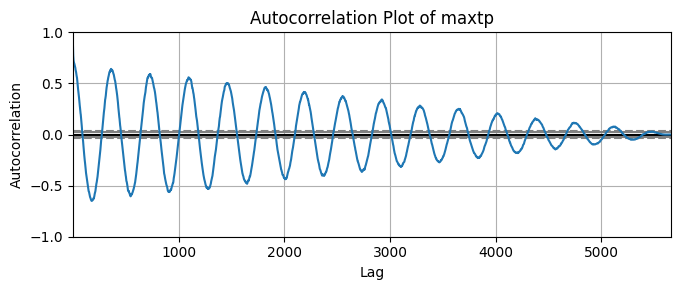

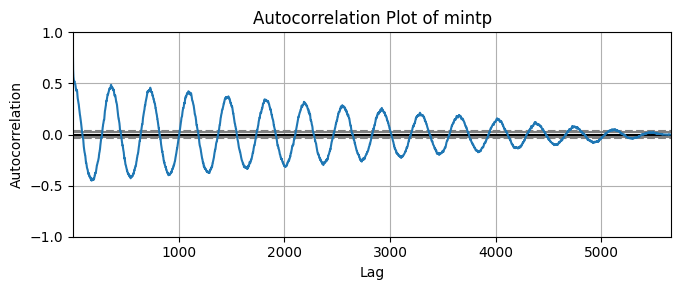

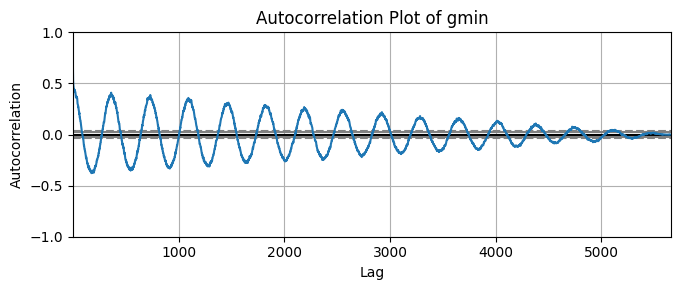

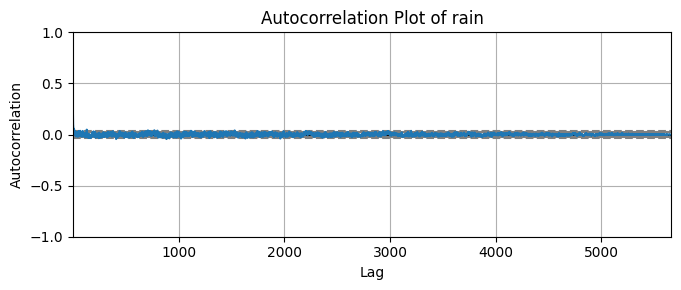

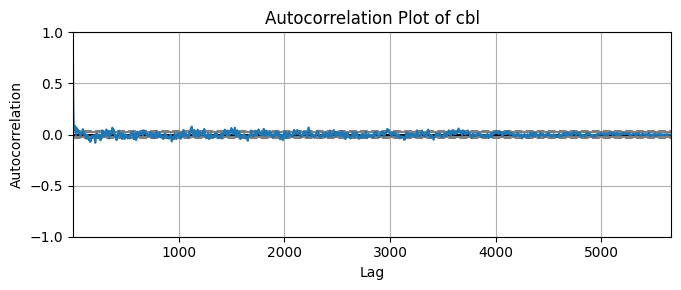

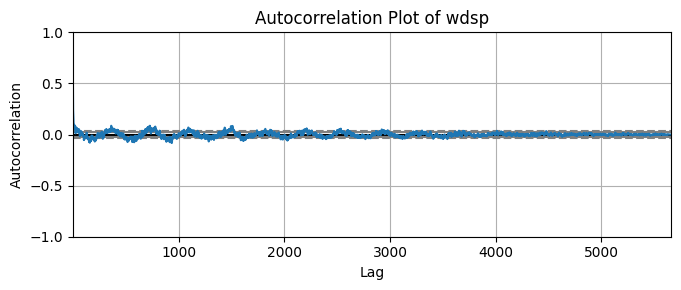

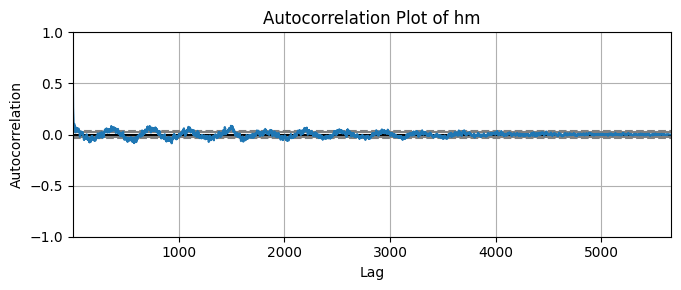

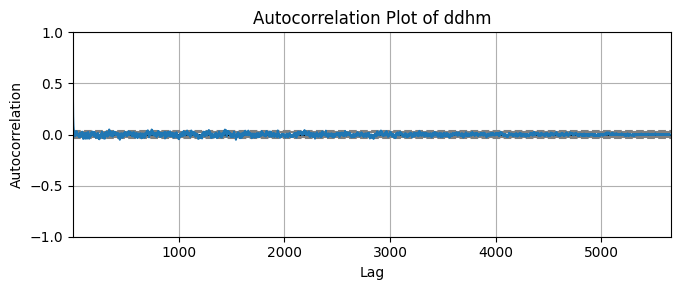

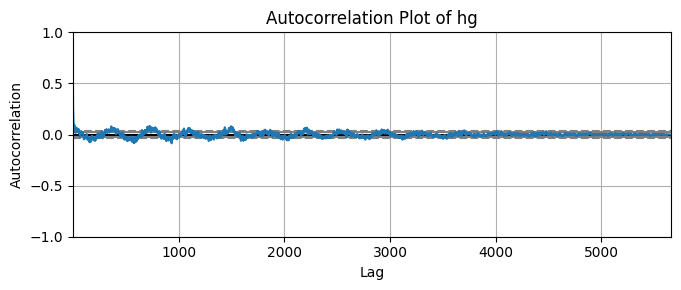

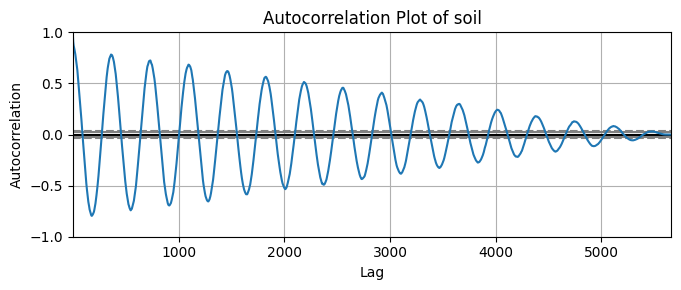

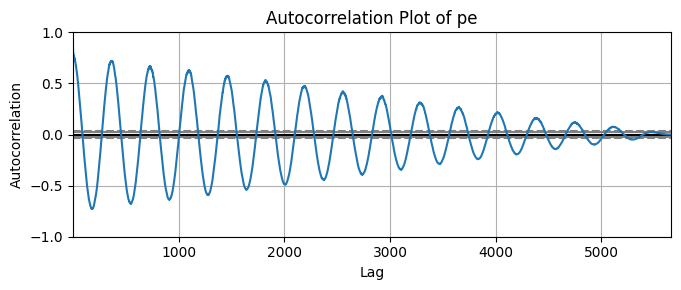

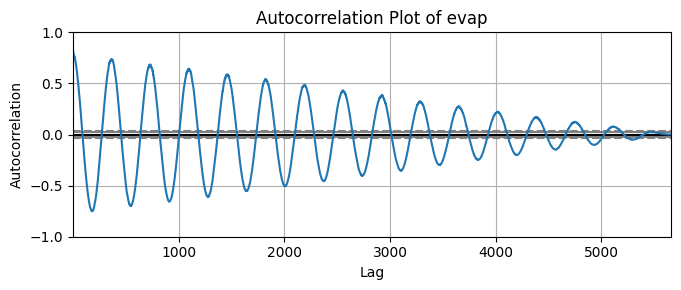

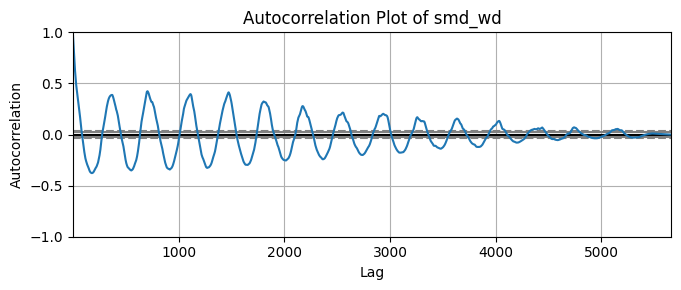

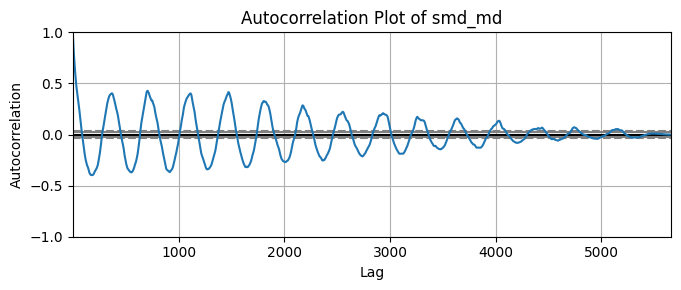

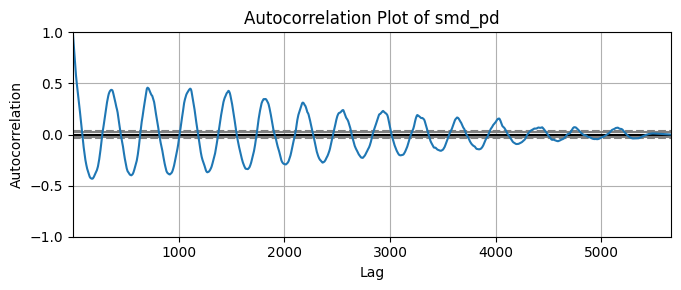

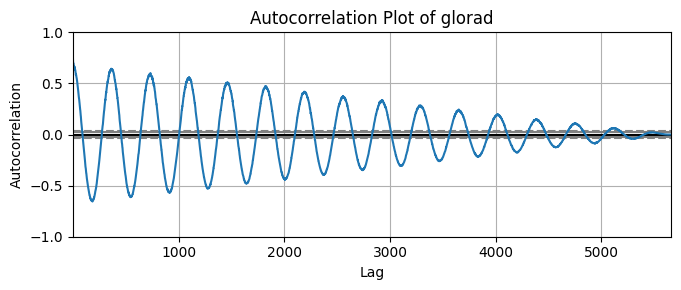

In [ ]:
# Loop through all columns except 'date' and plot their autocorrelation

""" An autocorrelation plot (ACF) shows how a series correlates with its own past values (lags).
    It helps reveal periodic cycles, trend, randomness, or lag relationships in a feature. """

for col in df.columns:                                # iterate over every column in the DataFrame
    if col.lower() == 'date':                         # skip the time index column named 'date' (case-insensitive)
        continue                                      # move to next column if it's 'date'

    plt.figure(figsize=(7, 3))                        # create a new figure with give size
    pd.plotting.autocorrelation_plot(df[col])         # draw the autocorrelation (ACF) plot for the current column
    plt.title(f'Autocorrelation Plot of {col}', fontsize=12)  # set a descriptive title
    plt.xlabel('Lag')                                 # label x-axis as lag (number of periods shifted)
    plt.ylabel('Autocorrelation')                     # label y-axis as correlation coefficient
    plt.tight_layout()                                # reduce padding so labels/titles fit nicely
    plt.show()                                        # render the plot


##Seasonality

In [ ]:
"""Seasonality means a repeating pattern in your data that occurs at regular, predictable intervals, such as every day, week, month, or year. """


for c in df.select_dtypes(include='number'):                 # iterate over each numeric column in the DataFrame
    print(f"\n{c}")                                          # print the column name as a header

    for p in [7, 30, 365]:                                   # test common seasonality periods: weekly, monthly, yearly
        r = STL(df[c].astype(float), period=p, robust=True).fit()  # run STL decomposition on the column with given period
        strength = 1 - np.var(r.resid) / np.var(r.observed)  # compute seasonal strength: 1 - Var(residual)/Var(original); closer to 1 ⇒ stronger seasonality
        print(f"  period={p}: {strength:.2f}")               # show the estimated seasonal strength for this period (2 decimal places)



maxtp
  period=7: 0.84
  period=30: 0.80
  period=365: 0.76

mintp
  period=7: 0.75
  period=30: 0.68
  period=365: 0.64

gmin
  period=7: 0.69
  period=30: 0.63
  period=365: 0.58

rain
  period=7: 0.14
  period=30: 0.07
  period=365: 0.07

cbl
  period=7: 0.58
  period=30: 0.37
  period=365: 0.24

wdsp
  period=7: 0.47
  period=30: 0.34
  period=365: 0.30

hm
  period=7: 0.47
  period=30: 0.35
  period=365: 0.29

ddhm
  period=7: 0.34
  period=30: 0.33
  period=365: 0.25

hg
  period=7: 0.45
  period=30: 0.35
  period=365: 0.29

soil
  period=7: 0.94
  period=30: 0.91
  period=365: 0.87

pe
  period=7: 0.82
  period=30: 0.81
  period=365: 0.79

evap
  period=7: 0.83
  period=30: 0.82
  period=365: 0.81

smd_wd
  period=7: 0.91
  period=30: 0.74
  period=365: 0.34

smd_md
  period=7: 0.92
  period=30: 0.78
  period=365: 0.47

smd_pd
  period=7: 0.94
  period=30: 0.80
  period=365: 0.50

glorad
  period=7: 0.74
  period=30: 0.73
  period=365: 0.72


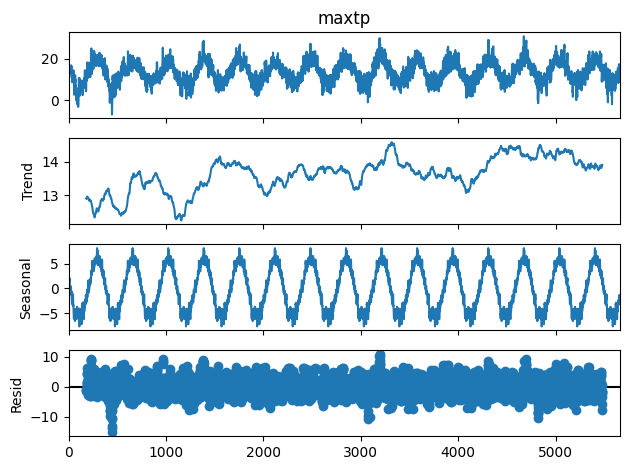

In [ ]:
""" Decompose variable with strong seasonality into trend, seasonal, and residual components, necessary to implement algorithms such as ARIMA """

res = sm.tsa.seasonal_decompose(df['maxtp'], model='additive', period=365) #maxtp seems to have additive seasonility


fig = res.plot() # Create a matplotlib Figure with the observed, trend, seasonal, and residual subplots

# Render the plots to the output
plt.show()


##Stationality

###KPSS Test


In [ ]:
""" stationarity means that a time series’ statistical properties such as mean, variance, and autocorrelation, remain constant over time
it is necessary to know if a variable is stationary or not to decide whether to apply ARMA or ARIMA """

stats, p, lags, critical_values = kpss(df['wdsp'], 'c') #wdsp does not have seasonility hence use c
if p < 0.05 :
  print('Series is not Stationary') # If p-value < 0.05, reject the null hypothesis of stationarity ⇒ evidence the series is NOT stationary.
else:
  print('Series is Stationary') # If p-value ≥ 0.05, fail to reject stationarity ⇒ treat the series as stationary at the chosen level.


Series is Stationary


###adfuller test

In [ ]:
result = adfuller(df['wdsp'])                 # Augmented Dickey-Fuller test on the 'wdsp' series


if result[1] > 0.05 :                         # result[1] is the p-value; > 0.05 ⇒ fail to reject H0 (non-stationary)
  print('Series is not Stationary')           # conclusion at 5% significance: treat as NOT stationary
else:
  print('Series is Stationary')               # p ≤ 0.05 then reject H0: evidence the series IS stationary


Series is Stationary


#Forecasting

In [ ]:
# Stacked Ensemble for 1-day & 7-day ahead forecasting


rmse = lambda y, yh: float(np.sqrt(mean_squared_error(y, yh)))     # compact RMSE function to avoid sklearn version issues

# --- Leakage-safe feature engineering ---
def create_features(df):                                           # build features without looking into the future
    df = df.copy(); df.index = pd.to_datetime(df.index)            # work on a copy; ensure DatetimeIndex for time features

    # Calendar signals (no leakage)
    df["dayofweek"] = df.index.dayofweek                           # weekday number (Mon=0 … Sun=6)
    df["dayofyear"] = df.index.dayofyear                           # day-of-year (1…365/366)
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)          # weekend flag (Sat/Sun -> 1)

    # Base lags (past values only)
    for lag in [1, 2, 3, 7, 14]:                                   # short and weekly lag distances
        for v in ["maxtp", "mintp", "rain"]:                       # for these variables if present
            if v in df: df[f"{v}_lag_{lag}"] = df[v].shift(lag)    # create lagged columns (introduces NaNs at head)

    # Weekly multiples (useful for t+7)
    for lag in [21, 28]:                                           # longer weekly multiples for longer horizon memory
        for v in ["maxtp", "mintp", "rain"]:
            if v in df: df[f"{v}_lag_{lag}"] = df[v].shift(lag)    # add additional lags

    # Rolling past stats (shift(1) avoids look-ahead)
    for w in [3, 7, 14, 21, 28]:                                   # window sizes for rolling stats
        if "maxtp" in df:                                          # compute only if target exists
            df[f"maxtp_mean_{w}"] = df["maxtp"].shift(1).rolling(w).mean()  # past window mean (exclude current row)
            df[f"maxtp_std_{w}"]  = df["maxtp"].shift(1).rolling(w).std()   # past window std (exclude current row)

    # Exponentially weighted means (react to changes)
    if "maxtp" in df:
        df["maxtp_ewm_7"]  = df["maxtp"].shift(1).ewm(span=7,  adjust=False).mean()  # short term EWM of past values
        df["maxtp_ewm_30"] = df["maxtp"].shift(1).ewm(span=30, adjust=False).mean()  # medium term EWM of past values

    # Fourier annual seasonality (smooth periodic terms)
    for K in [1, 2, 3]:                                            # first three harmonics for annual cycle
        df[f"s_{K}"] = np.sin(2*np.pi*K*df["dayofyear"]/365.0)     # sine term (seasonality)
        df[f"c_{K}"] = np.cos(2*np.pi*K*df["dayofyear"]/365.0)     # cosine term (seasonality)

    return df.dropna()                                             # drop rows with NaNs from shifts/rolls

# --- Ensure chronological order (assumes df already exists) ---
df = df.sort_index()                                               # sort by time to preserve order

# --- Build features / config ---
Xy = create_features(df)                                           # engineer features from the raw df
TARGET, TEST_SPLIT, TOP_K = "maxtp", 0.2, 25                       # target column; test proportion; top-K features to keep

# Base learners after GridSearch CV
ridge = Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, positive=False, solver="auto", tol=1e-4)  # linear
rf    = RandomForestRegressor(n_estimators=200, max_depth=8, min_samples_split=5, min_samples_leaf=1,             # Trea Ensemble
                              bootstrap=True, max_features=1.0, random_state=42)
gb    = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3,                              # Tree Ensemble
                                  loss="squared_error", random_state=42)

for h in [1, 7]:                                                   # iterate over horizons: 1-day and 7-day ahead
    # ---- Prepare horizon-specific data (direct y_{t+h}) ----
    y = Xy[TARGET].shift(-h).dropna()                              # future target aligned with current features
    X = Xy.drop(columns=[TARGET]).iloc[:-h].select_dtypes(include=[np.number]).loc[y.index]  # align X_t rows to y_{t+h}
    X = X.assign(horizon=h)                                        # add a simple horizon flag (same value in the fold)

    # ---- Chronological split: train/test ----
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=TEST_SPLIT, shuffle=False)  # keep order intact

    # ---- Inner split: train0 (fit base) / val (learn stack weights) ----
    Xtr0, Xval, ytr0, yval = train_test_split(Xtr, ytr, test_size=0.2, shuffle=False) # small validation from the front

    # ---- Scale + SelectKBest (fit ONLY on train0 to avoid leakage) ----
    ss = StandardScaler().fit(Xtr0)                                 # fit scaler on inner-train only
    Xt0, Xv, Xte_s = ss.transform(Xtr0), ss.transform(Xval), ss.transform(Xte)  # scale inner-train, val, and test
    sel = SelectKBest(f_regression, k=min(TOP_K, Xt0.shape[1])).fit(Xt0, ytr0) # choose top-K features on inner-train
    Xt0, Xv, Xte_s = sel.transform(Xt0), sel.transform(Xv), sel.transform(Xte_s) # apply selection to all splits

    # ---- Optional nonlinearity for t+7 (helps longer horizon) ----
    use_poly = (h == 7)                                            # only expand for the 7 days
    if use_poly:
        poly = PolynomialFeatures(degree=2, include_bias=False)    # create 2nd degree interactions/quadratics
        Xt0, Xv, Xte_s = poly.fit_transform(Xt0), poly.transform(Xv), poly.transform(Xte_s)  # fit on inner-train; transform others

    # ---- Fit base models on train0 ----
    ridge.fit(Xt0, ytr0); rf.fit(Xt0, ytr0); gb.fit(Xt0, ytr0)     # train each base model on inner-train

    # ---- Learn stacking weights on validation (no intercept = pure linear blend) ----
    Pv = np.c_[ridge.predict(Xv), rf.predict(Xv), gb.predict(Xv)]  # validation predictions matrix (cols: ridge, rf, gb)
    stack = LinearRegression(fit_intercept=False).fit(Pv, yval)    # fit linear blender to map preds -> targets
    w = stack.coef_                                                # learned weights [w_ridge, w_rf, w_gb]

    # ---- Refit base models on full train (same transforms) ----
    Xt = ss.transform(Xtr); Xt = sel.transform(Xt); Xt = poly.transform(Xt) if use_poly else Xt  # reapply pipeline to full train
    ridge.fit(Xt, ytr); rf.fit(Xt, ytr); gb.fit(Xt, ytr)             # refit base models on full train split

    # ---- Test predictions + stacked ensemble ----
    Pt  = np.c_[ridge.predict(Xte_s), rf.predict(Xte_s), gb.predict(Xte_s)]  # test predictions from each base model
    ens = Pt @ w                                                             # weighted blend using learned weights


    title = "1-Day Ahead Forecast (Stacked Ensemble)" if h == 1 else "7-Day Ahead Forecast (Stacked Ensemble)"  # title per horizon
    print("\n" + "="*80)                                            # visual separator
    print(f"=== {title} ===")                                       # section header
    print("="*80)                                                   # visual separator
    print(f"R² {r2_score(yte, ens):.4f} | RMSE {rmse(yte, ens):.4f} | MAE {mean_absolute_error(yte, ens):.4f}")  # ensemble metrics



=== 1-Day Ahead Forecast (Stacked Ensemble) ===
R² 0.7902 | RMSE 2.3345 | MAE 1.8346

=== 7-Day Ahead Forecast (Stacked Ensemble) ===
R² 0.6372 | RMSE 3.0689 | MAE 2.4270


#Limitations of forecasting model

<ol>
  <li>Dropping missing rows (no imputation) is unsuitable for continuous time series where current values depend on past values.</li>
  <li>Stack weights learned on a single validation slice lead to risk of overfitting.</li>
  <li>Fixed hyperparameters and hard-coded lags/seasonality may not fit the data.</li>
  <li>Univariate <code>SelectKBest</code> can drop useful interactions/nonlinear signals.</li>
  <li>No outlier handling, drift detection, or prediction intervals.</li>
  <li>Single static holdout split; no rolling backtests for stability.</li>
  <li>Assumes daily cadence; gaps/duplicates can distort lags/rolls.</li>
</ol>
